Source From [Here](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) and [JFormula](http://localhost/jforum/posts/list/4584.page)

## <font color='darkblue'>LDA Implementation</font>
The complete code is available as a [Jupyter Notebook on GitHub](https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Introduction%20to%20Topic%20Modeling.ipynb)
1. Loading data
2. Data cleaning
3. Exploratory analysis
4. Preparing data for LDA analysis
5. LDA model training
6. Analyzing LDA model results


### <font color='darkgreen'>Loading data</font>
For this tutorial, we’ll use the dataset of papers published in NIPS conference. The <b>[NIPS conference](https://en.wikipedia.org/wiki/Conference_on_Neural_Information_Processing_Systems)</b> (Neural Information Processing Systems) is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

Let’s start by looking at the content of the file `papers.csv` (Download [`NIPS Papers.zip`](https://github.com/kapadias/mediumposts/blob/master/nlp/data/NIPS%20Papers.zip) and unzip it)

In [1]:
# Importing modules
import pandas as pd
import os
import sys

print(sys.version)

# Read data into papers
papers = pd.read_csv('data/papers.csv')
# Print head
papers.head()

3.6.7 (v3.6.7:6ec5cf24b7, Oct 20 2018, 13:35:33) [MSC v.1900 64 bit (AMD64)]


,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


### <font color='darkgreen'>Data Cleaning</font>
Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data from each paper, and drop other metadata columns

In [2]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1)
# Show whole data shape
print("Original data shape={}".format(papers.shape))
# Randomally select 1000 rows
papers = papers.sample(n=100)
print("Downsizing the data with shape={}".format(papers.shape))
# Print out the first rows of papers
papers.head()

Original data shape=(6560, 4)
Downsizing the data with shape=(100, 4)


,year,title,abstract,paper_text
125,1995,Learning Model Bias,Abstract Missing,Learning Model Bias\n\nJonathan Baxter\nDepart...
1295,1989,Real-Time Computer Vision and Robotics Using A...,Abstract Missing,"750\n\nKoch, Bair, Harris, Horiuchi, Hsu and L..."
6385,1993,Agnostic PAC-Learning of Functions on Analog N...,Abstract Missing,Agnostic PAC-Learning of Functions on\nAnalog ...
4939,2014,Decomposing Parameter Estimation Problems,We propose a technique for decomposing the par...,Decomposing Parameter Estimation Problems\n\nK...
3681,2011,Comparative Analysis of Viterbi Training and M...,We present an asymptotic analysis of Viterbi T...,Comparative Analysis of Viterbi Training and\n...


#### Remove punctuation/lower casing
Next, let’s perform a simple preprocessing on the content of `paper_text` column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [3]:
# Load the regular expression library
import re
from nltk.stem import PorterStemmer

# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Remove none alphabic character(s)
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: re.sub('[~\'(){}:;+-=*"&]', ' ', x))
# Remove number
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: re.sub('[0-9]+', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower().strip())
# Stemming
porter = PorterStemmer()
def stemming(text):    
    return ' '.join(list(map(lambda w: porter.stem(w), filter(lambda w: len(w)>3, text.split()))))

papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: stemming(x))
# Remove unwanted words
skip_words = set(['thi'])
def remove_swords(text):
    words = text.split()
    return ' '.join(list(filter(lambda w: w not in skip_words, words)))

papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: remove_swords(x))

# Print out the first rows of papers
papers['paper_text_processed'].head()

125     learn model bia jonathan baxter depart comput ...
1295    koch bair harri horiuchi real time comput visi...
6385    agnost learn function analog neural net extend...
4939    decompos paramet estim problem khale refaat ar...
3681    compar analysi viterbi train maximum likelihoo...
Name: paper_text_processed, dtype: object

In [4]:
papers['paper_text_processed'][125]

'learn model bia jonathan baxter depart comput scienc royal holloway colleg univers london dcsrhbncacuk abstract paper problem learn appropri domain specif bia address shown that achiev learn mani relat task from same domain theorem given bound number task that must learnt corollari theorem that task known possess common intern represent preprocess then number exampl requir task good generalis when learn task simultan scale like where bound minimum number exampl requr learn singl task bound number exampl requir learn each task independ experi provid strong qualit support theoret result report introduct been argu that main problem machin learn bias learner hypothesi space suffici well ensur good generalis from small number exampl onc suitabl bias have been found actual learn task rel trivial exisit method bia gener requir input human expert form heurist hint domain knowledg such method clearli limit accuraci reliabl expert knowledg also extent which that knowledg transfer learner here a

#### Exploratory Analysis
To verify whether the preprocessing happened correctly, we’ll make a word cloud using the [**wordcloud**](https://github.com/amueller/word_cloud) package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

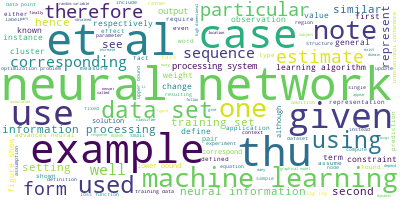

In [48]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", 
                      max_words=5000, 
                      contour_width=3, 
                      contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### Prepare text for LDA Analysis
Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words [BOW](https://en.wikipedia.org/wiki/Bag-of-words_model)). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.

We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.95)

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(papers['paper_text_processed'])
print(count_data.shape)

(100, 10638)


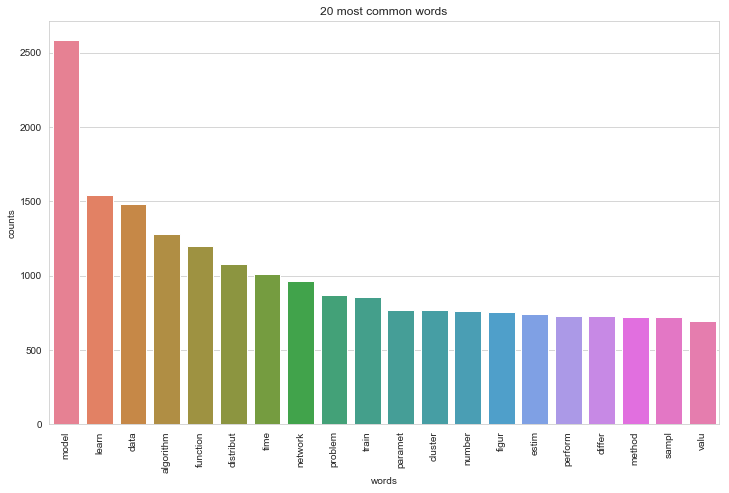

In [6]:
# Load the library with the CountVectorizer method
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_n_most_common_words(count_data, count_vectorizer, top_n=10):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:top_n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(12, 12/1.6180))
    plt.subplot(title='{} most common words'.format(top_n))
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Visualise top N most common words
plot_n_most_common_words(count_data, count_vectorizer, top_n=20)

In [5]:
# optional
!pip install stanfordnlp

In [6]:
# optional
import stanfordnlp

# stanfordnlp.download('en')   # This downloads the English models for the neural pipeline
# nlp = stanfordnlp.Pipeline() # This sets up a default neural pipeline in English
# doc = nlp("This downloads the English models for the neural pipeline.")

In [34]:
for sent in doc.sentences:
    print(list(map(lambda w: w.text, sent.words)))

['This', 'downloads', 'the', 'English', 'models', 'for', 'the', 'neural', 'pipeline', '.']


#### LDA model training and results visualization
To keep things simple, we will only tweak the number of topic parameters.

In [7]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print("/".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
model/imag/learn/data/represent/object/network/unit/train/input

Topic #1:
data/cluster/algorithm/classifi/learn/bound/kernel/function/estim/method

Topic #2:
model/function/algorithm/distribut/learn/paramet/time/data/problem/bound

Topic #3:
model/topic/word/data/document/figur/network/memori/perform/distribut

Topic #4:
model/learn/state/algorithm/function/filter/time/problem/sampl/observ


#### Analyzing LDA model results
Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:
1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [8]:
# optional 
!pip install pyLDAvis

In [9]:
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if not os.path.isfile(LDAvis_data_filepath):
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

c:\users\johnlee\appdata\local\programs\python\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## <font color='darkblue'>Closing Notes</font>
Machine learning has become increasingly popular over the past decade, and recent advances in computational availability have led to exponential growth to people looking for ways how new methods can be incorporated to advance the field of Natural Language Processing.

Often, we treat topic models as black-box algorithms, but hopefully, this post addressed to shed light on the underlying math, and intuitions behind it, and high-level code to get you started with any textual data.

In the next article, we’ll go one step deeper into understanding how you can evaluate the performance of topic models, tune its hyper-parameters to get more intuitive and reliable results.

### <font color='green'>Sources</font>
* [1] Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_model
* [2] Distributed Strategies for Topic Modeling. https://www.ideals.illinois.edu/bitstream/handle/2142/46405/ParallelTopicModels.pdf?sequence=2&isAllowed=y
* [3] Topic Mapping — Software — Resources — Amaral Lab. https://amaral.northwestern.edu/resources/software/topic-mapping
* [4] A Survey of Topic Modeling in Text Mining. https://thesai.org/Downloads/Volume6No1/Paper_21-A_Survey_of_Topic_Modeling_in_Text_Mining.pdf